In [1]:
# This notebook handles making even triangulations of the trimming patches of a wing 

# Depends on interaction in matplotlib and jupyter
# to get pygmsh do: pip install gmsh 
# conda install ipympl


In [1]:
from wingflattenfuncs import P2, P3
from wingflattenfuncs import WingShape
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)
# approximately flat and in metres (based around section 7) without the compression at the leading edge

No pygmsh here
Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


In [2]:
%matplotlib widget

from matplotlib import pyplot as plt
import pygmsh

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,2,0.2], zoom=1.3)

uvsq = [(wingshape.urange[0], wingshape.vrange[0]), (wingshape.urange[0], wingshape.vrange[1]), 
        (wingshape.urange[1], wingshape.vrange[1]), (wingshape.urange[1], wingshape.vrange[0])]
with pygmsh.geo.Geometry() as g:
    g.add_polygon(uvsq, mesh_size=0.1)
    mesh = g.generate_mesh()
pts = numpy.array([wingshape.seval(p)  for p in mesh.points])
ax.plot_trisurf(pts[:,0], pts[:,2], Z=pts[:,1], triangles=mesh.cells_dict["triangle"])

us = numpy.linspace(wingshape.urange[0], wingshape.urange[1], 20)
vs = numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 20)
for u in us:
    ps = [wingshape.seval(P2(u, v))  for v in vs]
    plt.plot([p[0] for p in ps], [p[2] for p in ps], [p[1] for p in ps], color="red")
for v in vs:
    ps = [wingshape.seval(P2(u, v))  for u in us]
    plt.plot([p[0] for p in ps], [p[2] for p in ps], [p[1] for p in ps], color="green")



ModuleNotFoundError: No module named 'pygmsh'

In [3]:
mesh_size = 0.02

from wingflattenfuncs import loadwingtrimlines, trimlinestopolygons, exportpolygonsobj

trimfile = "segmentedwing.txt"
nodes, paths = loadwingtrimlines(trimfile)
    # This converts from the [0,1]x[0,1] parametrization to the flatter urange x vrange one
for n in nodes.keys():
    nodes[n] = wingshape.sevalconvO(P2(nodes[n][1], nodes[n][0]))  
exportpolygonsobj("meshpatches.obj", nodes, paths, wingshape, 0.02)    

# Load the above into Blender.
# Select all the patch meshes
# Modelling tab, object mode, Object->join
# Select a patch in edit mode with mouse and hit L for linked
# UV editing tab, select all (Ctrl-A) UV unwrap (not smart)


NameError: name 'pygmsh' is not defined

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
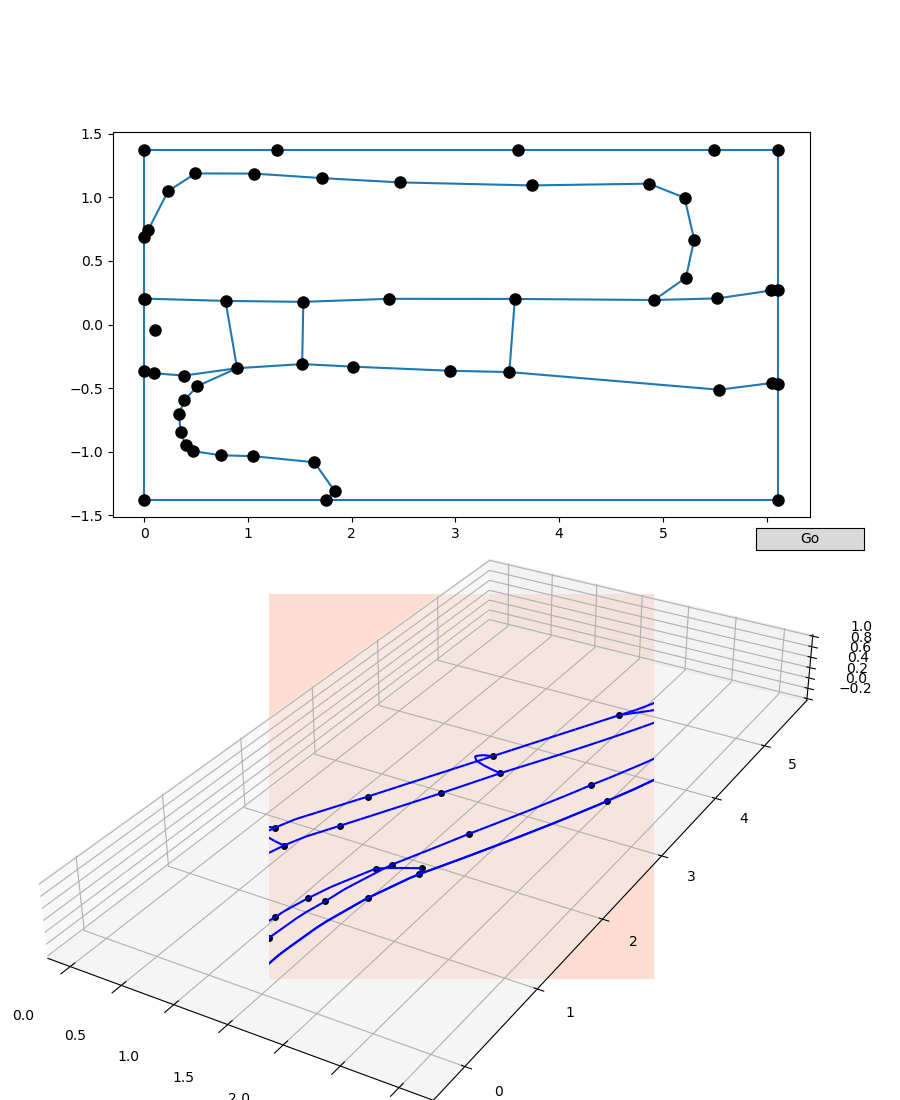

In [4]:
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from matplotlib.widgets import Button

rnodes = dict((nn, P2(p[1], -p[0]))  for nn, p in nodes.items())

def pointsdata():
    return zip(*rnodes.values())
def legsdata():
    return [[rnodes[paths[i]], rnodes[paths[i+1]]]  for i in range(0, len(paths), 2)]
def exchyz(p):
    return (p[0], p[2], p[1])
def points3ddata():
    res = [ ]
    for p in rnodes.values():
        res.append(exchyz(wingshape.seval((-p[1], p[0]))))
    return zip(*res)
def legs3ddata(step=0.25):
    res = [ ]
    for i in range(0, len(paths), 2):
        p0, p1 = rnodes[paths[i]], rnodes[paths[i+1]]
        n = max(1, int(math.ceil((p0 - p1).Len()/step)))
        p = wingshape.seval((-p0[1], p0[0]))
        for i in range(n):
            l = (i+1.0)/n
            pn = p0*(1-l) + p1*l
            pd = wingshape.seval((-pn[1], pn[0]))
            res.append([exchyz(p), exchyz(pd)])
            p = pd
    return res

fig = plt.figure(figsize=(9.0,11.0))
axpara = fig.add_subplot(2, 1, 1)
lc = mc.LineCollection(legsdata())
lupdater = axpara.add_collection(lc)
mupdater, = axpara.plot(*pointsdata(), color='k', linestyle='none', marker='o', markersize=8)
axpara.autoscale()

events = [ ]
nodenamedown = None

def button_press_callback(event):
    global nodenamedown
    if event.inaxes == axpara and event.button == 1:
        mp = P2(max(wingshape.vrange[0], min(wingshape.vrange[1], event.xdata)), 
                max(-wingshape.urange[1], min(-wingshape.urange[0], event.ydata)))
        l, nn = min(((mp - p).Len(), nn)  for nn, p in rnodes.items())
        if l < 0.1:
            nodenamedown = nn
        
def button_release_callback(event):
    global nodenamedown
    events.append(event)
    if event.button == 1 and nodenamedown is not None:
        nodenamedown = None
        lupdater.set_segments(legsdata())

def motion_notify_callback(event):
    if event.inaxes == axpara and nodenamedown is not None:
        rnodes[nodenamedown] = P2(event.xdata, event.ydata)
        mupdater.set_data(pointsdata())
        fig.canvas.draw_idle()
        
def buttongo(event):
    events.append(event)
    lupdater3d.set_segments(legs3ddata(0.1))
    #mupdater3d.set_data_3d(points3ddata())
    fig.canvas.draw_idle()

def key_press_callback(self, event):
    events.append(event)
    
    
ax3d = fig.add_subplot(2, 1, 2, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

from mpl_toolkits.mplot3d.art3d import Line3DCollection
lc3d = Line3DCollection(legs3ddata(0.1), color="blue")
lupdater3d = ax3d.add_collection(lc3d)
mupdater3d, = ax3d.plot(*points3ddata(), linestyle='none', marker='o', markersize=4, color="black")
ax3d.set_aspect('auto')
ax3d.set_facecolor((1.0, 0.87, 0.82))
    
axres = plt.axes([0.84, 0.5, 0.12, 0.02])
bres = Button(axres, 'Go')
bres.on_clicked(buttongo)
fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)
fig.canvas.mpl_connect('key_press_event', key_press_callback)

plt.show()

In [129]:
snodes = dict((nn, P2(-p[1], p[0]))  for nn, p in rnodes.items())
exportpolygonsobj("meshpatches_moved.obj", snodes, paths, wingshape, 0.02)    


In [126]:
lupdater3d.set_segments(legs3ddata(0.1))
mupdater3d.set_data_3d(points3ddata())


In [34]:

from wingflattenfuncs import P2, P3
from wingflattenfuncs import loadwingtrimlines, trimlinestopolygons
import pygmsh
import numpy

trimfile = "segmentedwing.txt"
nodes, paths = loadwingtrimlines(trimfile)
for n in nodes.keys():
    nodes[n] = wingshape.sevalconvO(nodes[n]) 

polys = trimlinestopolygons(nodes, paths)

plt.figure(figsize=(9,9))
for i in range(0, len(paths), 2):
    p0, p1 = nodes[paths[i]], nodes[paths[i+1]]
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]])
    
poly = polys[7]
X = [ nodes[p][0]  for p in poly ];  X.append(X[0])
Y = [ nodes[p][1]  for p in poly ];  Y.append(Y[0])
plt.plot(X, Y, linewidth=3, color="red")

poly = polys[5]
X = [ nodes[p][0]  for p in poly ];  X.append(X[0])
Y = [ nodes[p][1]  for p in poly ];  Y.append(Y[0])
plt.plot(X, Y, linewidth=2, color="blue")

poly = polys[1]
npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
with pygmsh.geo.Geometry() as g:
    g.add_polygon(npoly, mesh_size=0.05)
    mesh = g.generate_mesh()
X = mesh.points[:,0]
Y = mesh.points[:,1]
plt.triplot(X, Y, mesh.cells_dict["triangle"], color="green", linewidth=0.2)

plt.title("trimming lines/polys in parametric space");

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
#output obj file from points and triangles
filepath = "meshy.obj"
with open(filepath, 'w') as f:
    f.write("# OBJ file\n")
    f.write("o 1")
    for v in pts:
        f.write("v %.4f %.4f %.4f\n" % v)
    for t in mesh.cells_dict["triangle"]:
        f.write("f %d %d %d\n" % (t[0]+1,t[1]+1,t[2]+1))

In [31]:

filepath = "meshy-full.obj"

with open(filepath, 'w') as f:
    f.write("# OBJ file\n")
    qpts = [ ]
    lsec = len(sections[0])
    assert len(sections) == len(zvals)
    for usec in range(len(sections)):
        qpts.extend([P3(p[0], p[1], zvals[usec])  for p in sections[usec]])
        assert sections[usec][0] == sections[usec][-1]
        assert lsec == len(sections[usec])
    for v in qpts:
        f.write("v %.4f %.4f %.4f\n" % (v*1e-3))
    for usec in range(len(sections)-1):
        for i in range(lsec-1):
            quad = (usec*lsec+i+1, (usec+1)*lsec+i+1, (usec+1)*lsec+i+2, usec*lsec+i+2)
            f.write("f %d %d %d %d\n" % quad) 

In [4]:
import numpy
from wingflattenfuncs import trimeshesflattener, fullflattriareas, triprojpolyflattener

surfacemeshes = triprojpolyflattener(nodes, polys, sections, zvals, 0.02)



[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
Assembly4 workbench loaded 
mesh (pts=670, tris=1244) flattened
mesh (pts=677, tris=1247) flattened
mesh (pts=367, tris=664) flattened
mesh (pts=137, tris=225) flattened
mesh (pts=178, tris=302) flattened
mesh (pts=217, tris=366) flattened
mesh (pts=895, tris=1658) flattened
mesh (pts=673, tris=1189) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



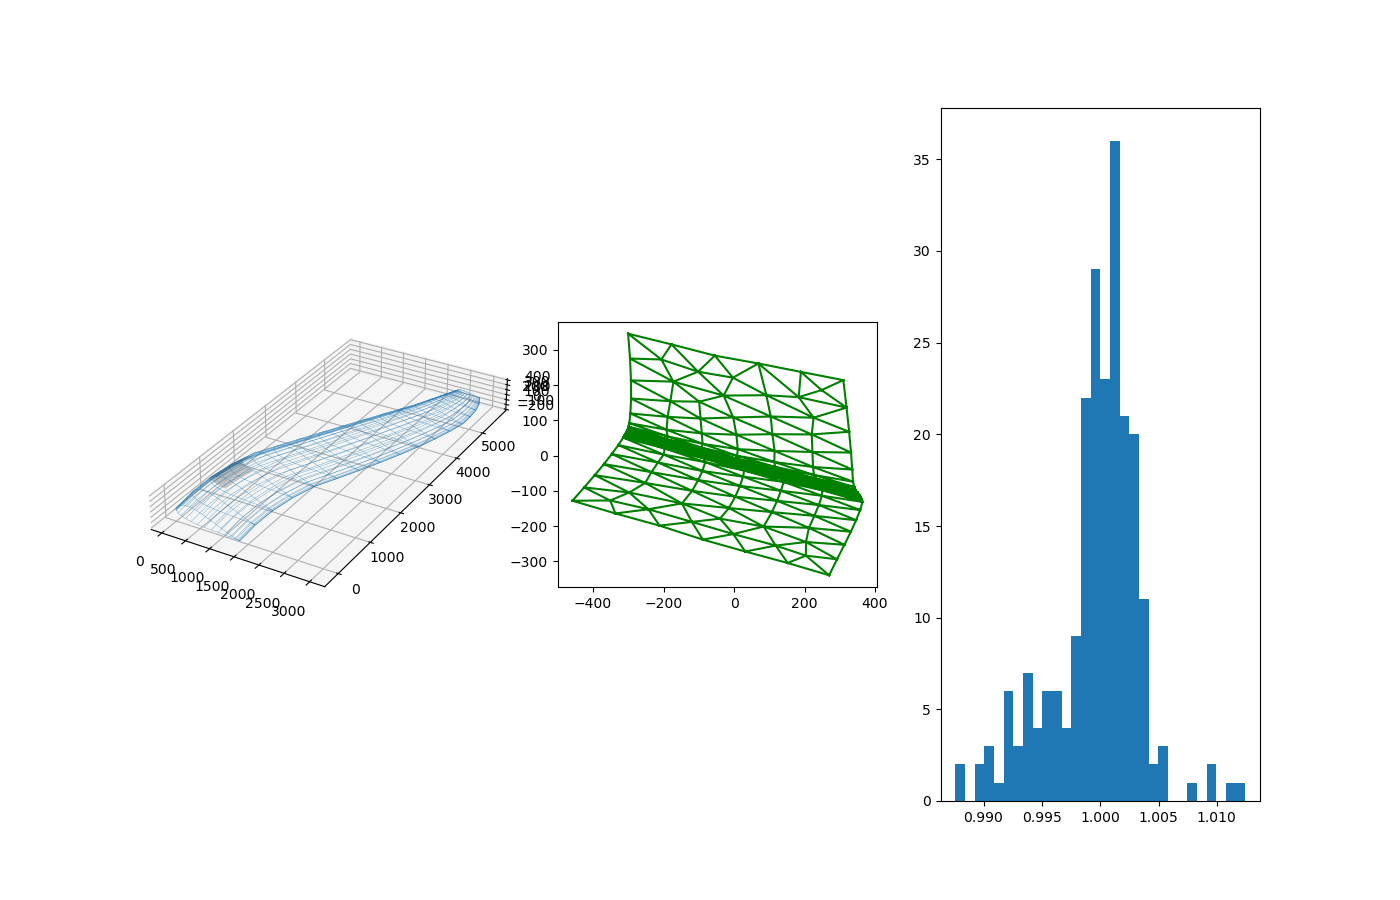

In [5]:
fig = plt.figure(figsize=(14,9))

surfacemesh = surfacemeshes[3]

pts = surfacemesh["pts"]
fpts = surfacemesh["fpts"]
tris = surfacemesh["tris"]
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_box_aspect([1,2,0.2], zoom=1.3)
ax.plot_wireframe(wX, wZ, wY, linewidth=0.2)
ax.plot_trisurf(pts[:,0], pts[:,2], Z=pts[:,1], triangles=tris, color="white")

fax = fig.add_subplot(1, 3, 2)
X = fpts[:,0]
Y = fpts[:,1]

fax.triplot(X, Y, tris, color="green")
fax.set_aspect("equal")

ax = fig.add_subplot(1, 3, 3)
triareas = fullflattriareas(surfacemesh)
ax.hist(triareas[:,1]/triareas[:,0], bins=30);

In [6]:

def fullflattriareas(surfacemesh):
    ptsP = [ P3(*p)  for p in surfacemesh["pts"] ]
    fptsP = [ P2(*p)  for p in surfacemesh["fpts"] ]
    tris = surfacemesh["tris"]

    def P2Cross(a, b):
        return a.u*b.v - b.u*a.v

    triareas = [ ]
    for tri in tris:
        p0, p1, p2 = ptsP[tri[0]], ptsP[tri[1]], ptsP[tri[2]]
        parea = 0.5*P3.Cross(p1 - p0, p2 - p0).Len()
        f0, f1, f2 = fptsP[tri[0]], fptsP[tri[1]], fptsP[tri[2]]
        farea = 0.5*abs(P2Cross(f1 - f0, f2 - f0))
        #areachange = farea/parea
        triareas.append([parea, farea])
    return numpy.array(triareas)


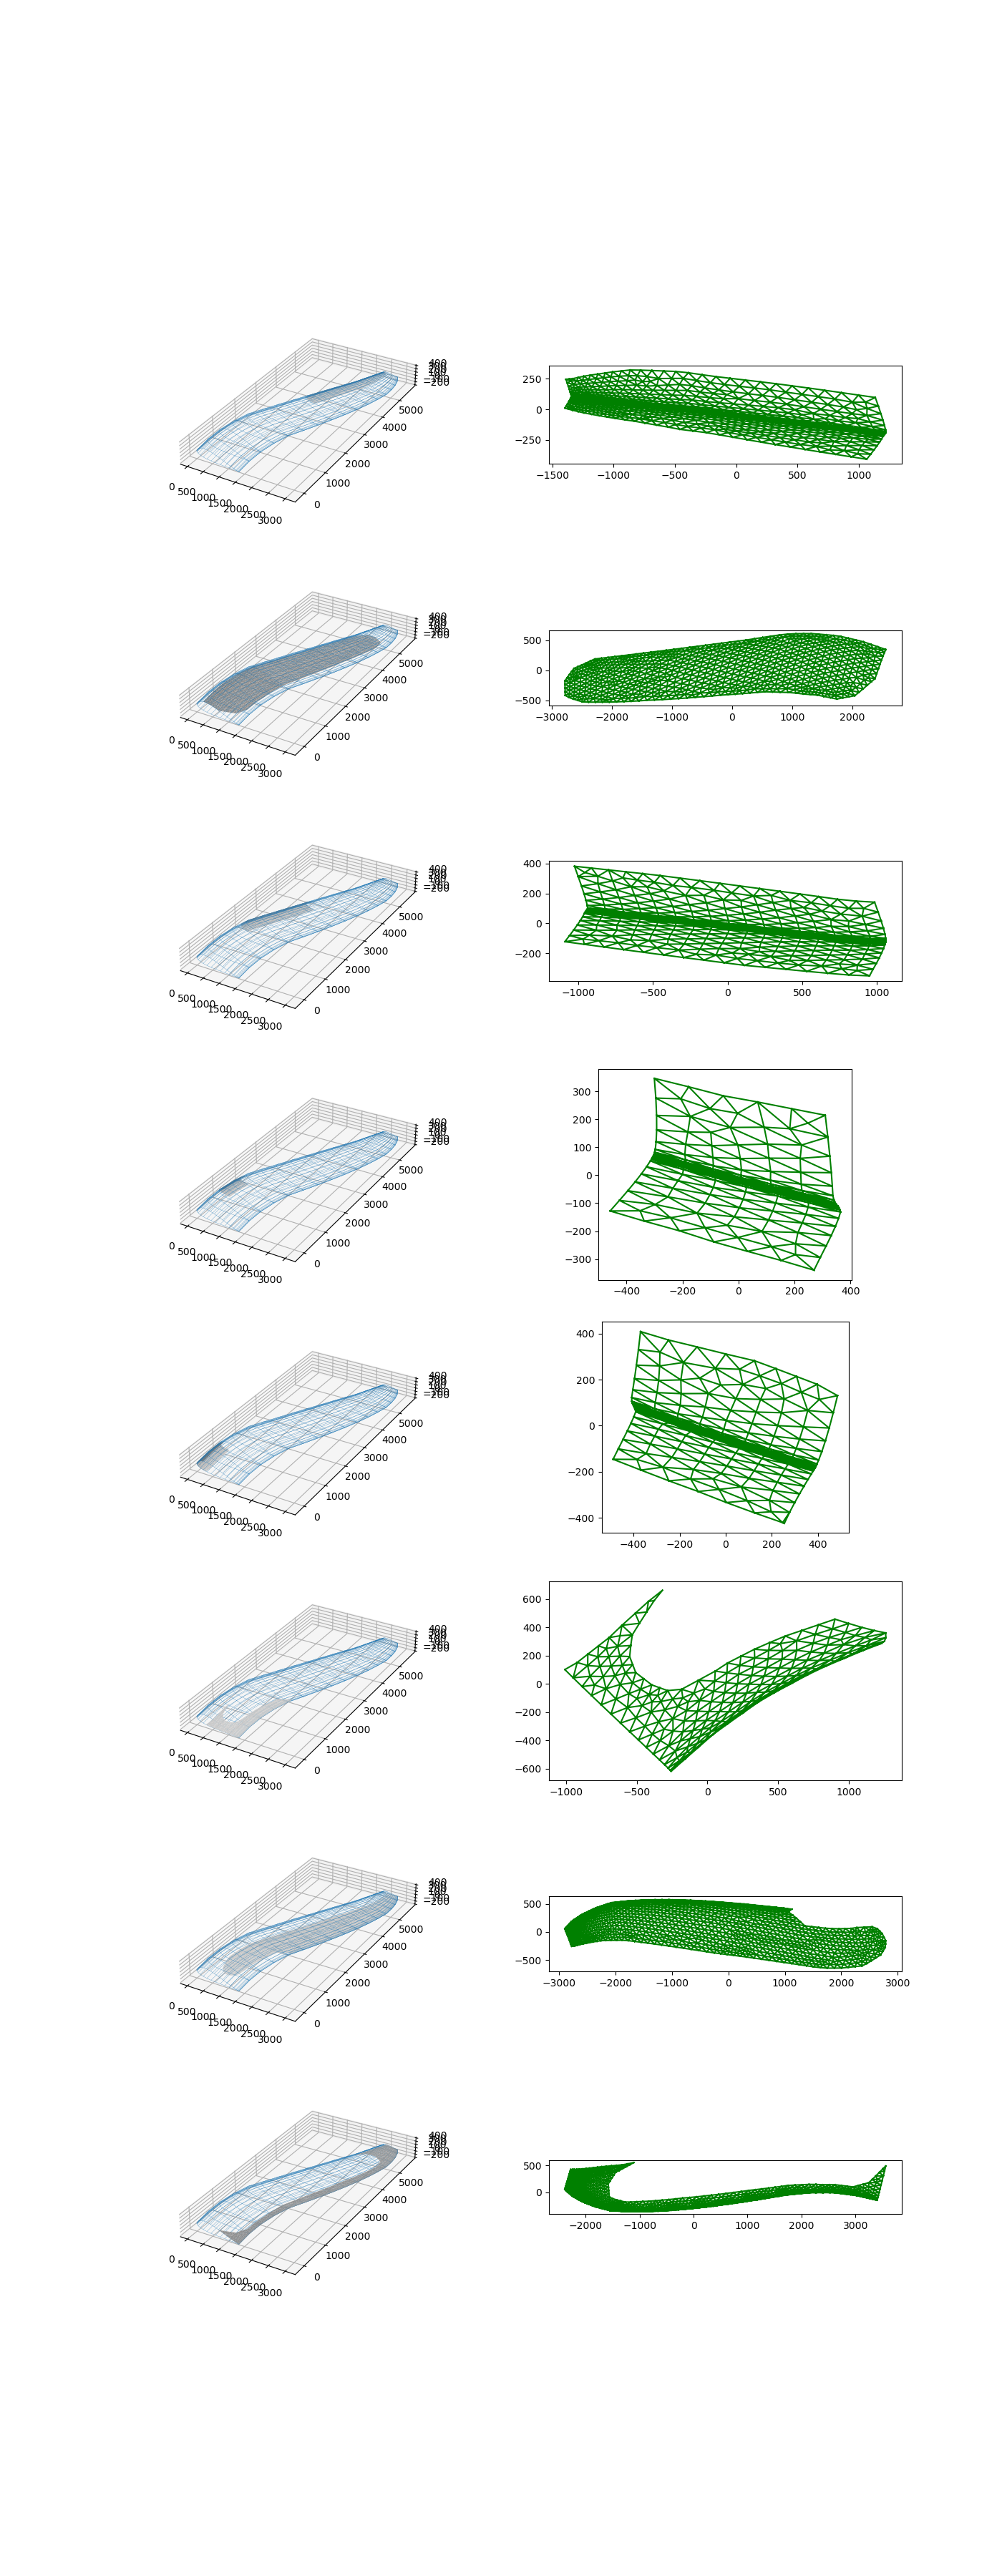

In [7]:
fig = plt.figure(figsize=(14,36))

nrows = len(surfacemeshes)
for i in range(nrows):
    surfacemesh = surfacemeshes[i]
    pts = surfacemesh["pts"]
    fpts = surfacemesh["fpts"]
    tris = surfacemesh["tris"]
    ax = fig.add_subplot(nrows, 2, i*2+1, projection='3d')
    ax.set_box_aspect([1,2,0.2], zoom=1.3)
    ax.plot_wireframe(wX, wZ, wY, linewidth=0.2)
    ax.plot_trisurf(pts[:,0], pts[:,2], Z=pts[:,1], triangles=tris, color="white")

    fax = fig.add_subplot(nrows, 2, i*2+2)
    X = fpts[:,0]
    Y = fpts[:,1]

    fax.triplot(X, Y, tris, color="green")
    fax.set_aspect("equal")
    triareas = fullflattriareas(surfacemesh)

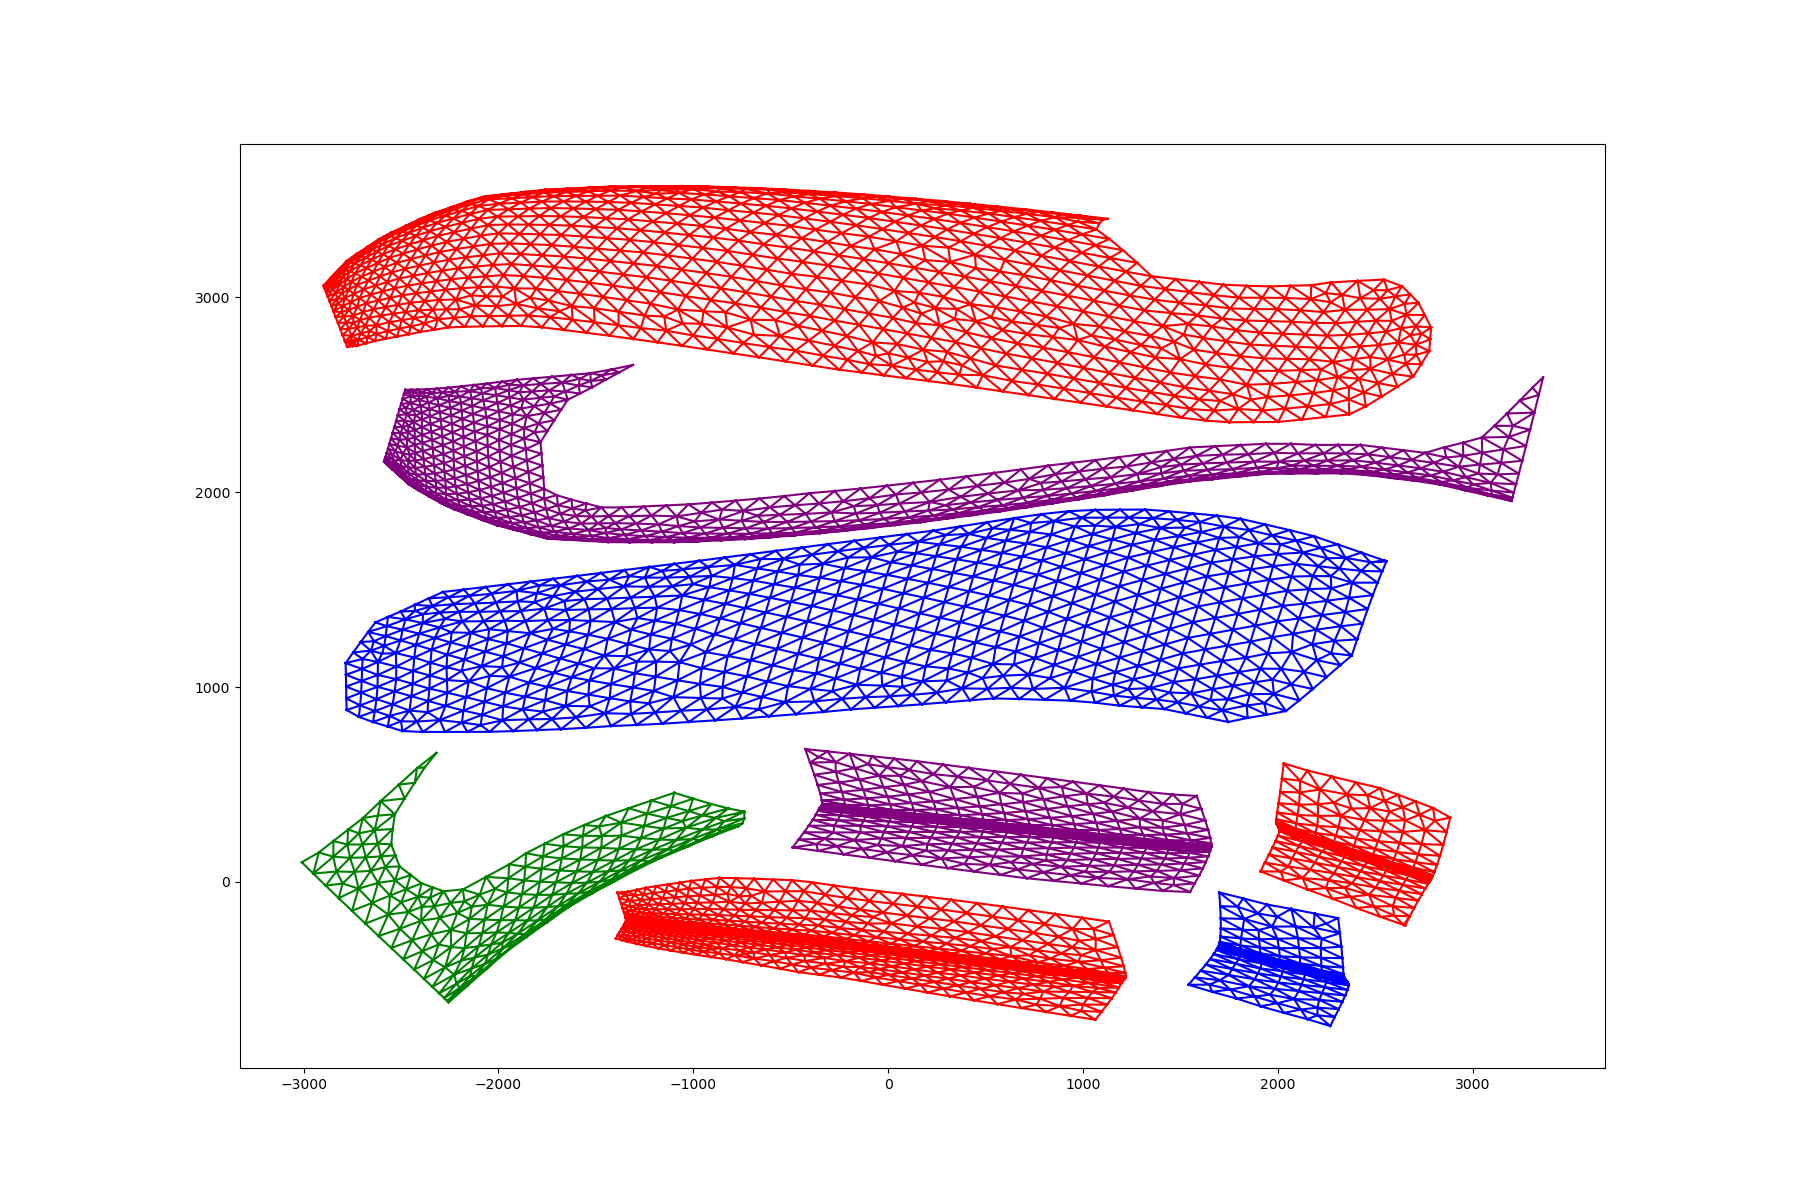

In [39]:
fig = plt.figure(figsize=(18,12))
coffsets = [(5, -2, 0, "green"), (1, 0, 1.3, "blue"), 
            (0, 0, -0.3, "red"), (2, 0.6, +0.3, "purple"),
            (3, 2, -0.4, "blue"), (4, 2.4, 0.2, "red"), 
            (6, 0, 3, "red"), (7, -0.2, 2.1, "purple")]
fax = fig.add_subplot()
for i, tx, ty, col in coffsets:
    surfacemesh = surfacemeshes[i]
    pts = surfacemesh["pts"]
    fpts = surfacemesh["fpts"]
    tris = surfacemesh["tris"]
    X = fpts[:,0]+tx*1000
    Y = fpts[:,1]+ty*1000
    fax.triplot(X, Y, tris, color=col)
    fax.set_aspect("equal")

In [9]:
import ipyvolume as ipv
ipv.figure()

for i,col in [(7,"red"), (1,"blue"), (0,"green")]:
    poly = polys[i]
    npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
    with pygmsh.geo.Geometry() as g:
        g.add_polygon(npoly, mesh_size=0.06)
        mesh = g.generate_mesh()

    pts = [ winguv2xyz(p[0], p[1], sections, zvals)  for p in mesh.points ]
    tX = [ p[0]  for p in pts ]
    tY = [ p[1]  for p in pts ]
    tZ = [ p[2]  for p in pts ]

    tris = mesh.cells_dict["triangle"]
    lines = list(tris[:,:2])+list(tris[:,1:])
    ipv.plot_trisurf(tX, tZ, tY, lines=lines, color=col)
    
ipv.show()

/home/timbo/anaconda3/lib/python3.8/site-packages/numpy/ctypeslib.py:517: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)
